<a href="https://colab.research.google.com/github/davidcpage/Imagenette-experiments/blob/master/Network_visualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This network demos networks visualisation based on https://github.com/davidcpage/cifar10-fast:

### Setup

Install fastai2 and DALI. You may need to restart afterwards.

In [0]:
!python -m pip install typeguard
!python -m pip install --upgrade pillow fastprogress
!python -m pip install git+https://github.com/fastai/fastai2
!python -m pip install --extra-index-url https://developer.download.nvidia.com/compute/redist/cuda/10.0 nvidia-dali

UTILS = 'https://raw.githubusercontent.com/davidcpage/Imagenette-experiments/master/utils.py'
RANGER = 'https://raw.githubusercontent.com/lessw2020/Ranger-Mish-ImageWoof-5/master/ranger.py'

!wget $RANGER -O ranger.py
!wget $UTILS -O utils.py

CORE = 'https://raw.githubusercontent.com/davidcpage/cifar10-fast/master/core.py'
!wget $CORE -O core.py

### Main

Imports, device setup and dataset download:

In [0]:
from functools import partial
import numpy as np
import torch
import torch.nn as nn
import fastai, fastai.vision
import fastai2, fastai2.callback.all

import ranger
from utils import *

data_dir = fastai.datasets.untar_data(fastai.datasets.URLs.IMAGENETTE_160)
device = torch.device(torch.cuda.current_device())

torch.backends.cudnn.benchmark = True

### DALI DataLoaders

In [0]:
size = 128
bs = 64
random_aspect_ratio = (3/4, 4/3)
random_area = (0.35, 1.)
val_xtra_size = 32

to = lambda dtype: (lambda b: (b[0].to(dtype), b[1]))

train_dl = lambda folder, bs, dtype=torch.float16: (
        Map(to(dtype), DALIDataLoader(imagenet_train_graph(folder, size, random_aspect_ratio, random_area), bs, drop_last=True, device=device)))
valid_dl = lambda folder, bs, dtype=torch.float16: Chain(
        Map(to(dtype), DALIDataLoader(imagenet_valid_graph(folder, size, val_xtra_size), bs, drop_last=False, device=device)),
        Map(to(dtype), DALIDataLoader(imagenet_valid_graph(folder, size, val_xtra_size, mirror=1), bs, drop_last=False, device=device)),
    )

data = lambda data_dir=data_dir, bs=bs, dtype=torch.float16: fastai2.basics.DataBunch(train_dl(data_dir/'train', bs, dtype), valid_dl(data_dir/'val', bs, dtype))

### Basic ops

In [0]:
from core import DotGraph, ColorMap, build_graph, remove_by_type

class Mul(nn.Module):
    def forward(self, x, y): return x * y

class Add(nn.Module):
    def forward(self, x, y): return x + y

class Identity(nn.Module):
    def forward(self, x): return x

class Noop(): 
    def __init__(self, *args, **kwargs): pass

class BatchNorm(nn.BatchNorm2d):
    def __init__(self, *args, zero=False, **kwargs):
        super().__init__(*args, **kwargs)
        if self.affine:
            self.weight.data.fill_(0. if zero else 1.)

class Network(nn.Module):
    def __init__(self, net):
        super().__init__()
        self.graph = remove_by_type(union({'input': (None, [])}, net), Noop)
        for path, (val, _) in self.graph.items(): 
            setattr(self, path.replace('/', '_'), val)
    
    def forward(self, x):
        outputs = {'input': x}
        for k, (node, ins) in self.graph.items():
            if k not in outputs: 
                outputs[k] = node(*[outputs[x] for x in ins])
        return outputs['classifier']

colors = ColorMap()
def draw(network, **kwargs):
    if not isinstance(network, Network):
        network = Network(network)
    return DotGraph({p: ({'fillcolor': colors[type(v).__name__], 'tooltip': repr(v)}, inputs) for p, (v, inputs) in network.graph.items() if v is not None}, **kwargs)

### Layers

In [4]:
def conv_layer(ni, nf, ks=3, stride=1, padding=None, groups=1, bias=None, norm=BatchNorm, act_cls=MishJit, conv=nn.Conv2d):
    return {
        'conv': nn.Conv2d(ni, nf, ks, stride=stride, padding=((ks-1)//2 if padding is None else padding), groups=groups, bias=bias),
        'norm': norm(nf), 
        'act': act_cls()
    }

draw(conv_layer(32,64), size=3)

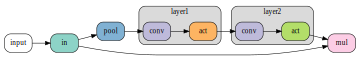

In [5]:
def se_module(ch, reduction):
    print
    return {
        'in': Identity(),
        'pool': nn.AdaptiveAvgPool2d(1),
        'layer1': conv_layer(ch, ch//reduction, ks=1, norm=Noop, bias=True, act_cls=nn.ReLU),
        'layer2': conv_layer(ch//reduction, ch, ks=1, norm=Noop, bias=True, act_cls=nn.Sigmoid),
        'mul': (Mul(), [-1, 'in']),
    }

draw(se_module(64, 16), size=5)

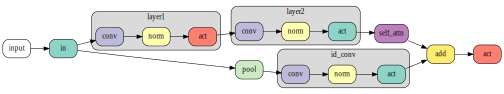

In [6]:
#res_block with expansion=1
def res_block_a(ni, nf, stride=1, groups=1, groups2=1, sa=True, reduction=None, nh=None, norm=BatchNorm, act_cls=MishJit):
    if nh is None: nh = nf
    return {
        'in': Identity(),
        'layer1': conv_layer(ni, nh, 3, stride=stride, groups=groups, norm=norm, act_cls=act_cls),
        'layer2': conv_layer(nh, nf, 3, groups=groups2, norm=partial(norm, zero=True), act_cls=Identity),
        'squeeze_excite': (se_module(nf, reduction=reduction) if reduction else Noop()),
        'self_attn': (fastai2.layers.SimpleSelfAttention(nf, ks=1, sym=0) if sa else Noop()),
        'pool': (Noop() if stride==1 else nn.AvgPool2d(2, ceil_mode=True), ['in']),
        'id_conv': (Noop() if ni==nf else conv_layer(ni, nf, ks=1, act_cls=Identity)),
        'add': (Add(), [-1, 'self_attn']),
        'act': act_cls(),
    }

draw(res_block_a(32, 64, stride=2), size=7)

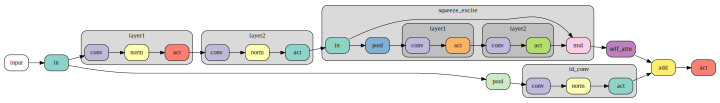

In [7]:
def separable_block(ni, nf, reduction=16, stride=1, **kwargs):
    return res_block_a(ni,  nf, stride=stride, reduction=reduction, nh=nf*2, groups=ni, **kwargs)

draw(separable_block(32, 64, stride=2), size=10)

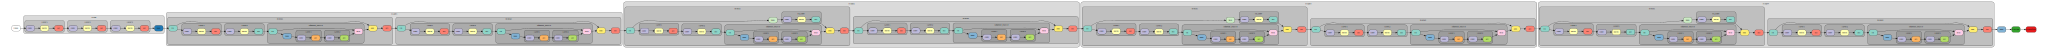

In [8]:
def xresnet(block, layers, p=None, c_in=3, c_out=1000, sa=False, act_cls=MishJit):
    sizes = [c_in, 16,32,64] if c_in < 3 else [c_in, 32, 64, 64]
    stem = dict({f'layer{i+1}': conv_layer(sizes[i], sizes[i+1],  stride=2 if i==0 else 1, act_cls=act_cls) for i in range(3)},
                pool=nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    block_szs = [64,64,128,256,512] +[256]*(len(layers)-4)
    def _make_layer(ni, nf, blocks, stride, sa):
        return {f'block{i+1}': block(ni if i==0 else nf, nf, stride=stride if i==0 else 1, 
                            sa=sa and i==(blocks-1), act_cls=act_cls) for i in range(blocks)}
    body = {f'stage{i+1}': _make_layer(ni=block_szs[i], nf=block_szs[i+1], blocks=l,
                                   stride=1 if i==0 else 2, sa=sa and i==len(layers)-4)
                  for i,l in enumerate(layers)}
    head = {
        'pool': nn.AdaptiveAvgPool2d(1), 
        'flatten': fastai2.layers.Flatten(),
        'dropout': (Noop() if p is None else nn.Dropout(p)),
        'classifier': nn.Linear(block_szs[-1], c_out)
    }
    return union({'stem': stem}, body, head)

draw(xresnet(separable_block, [2,2,2,2], c_out=10), size=50)

In [9]:
colors

{'AdaptiveAvgPool2d': '#80b1d3',
 'Add': '#ffed6f',
 'AvgPool2d': '#ccebc5',
 'BatchNorm': '#ffffb3',
 'Conv2d': '#bebada',
 'Flatten': '#33a02c',
 'Identity': '#8dd3c7',
 'Linear': '#e31a1c',
 'MaxPool2d': '#1f78b4',
 'MishJit': '#fb8072',
 'Mul': '#fccde5',
 'ReLU': '#fdb462',
 'Sigmoid': '#b3de69',
 'SimpleSelfAttention': '#bc80bd'}

In [0]:
def init_cnn(m):
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d, nn.Linear)): 
        nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)
    return m

def XResNet(block, layers, p=None, c_in=3, c_out=1000, sa=False, act_cls=MishJit):
    return init_cnn(Network(xresnet(block, layers, p=p, c_in=c_in, c_out=c_out, sa=sa, act_cls=act_cls)))

xresnet18 = partial(XResNet, separable_block, [2,2,2,2], c_out=10, sa=True, act_cls=MishJit)

### Training

In [0]:
RangerWrapper = lambda *args, **kwargs: fastai2.basics.OptimWrapper(ranger.Ranger(*args, **kwargs))

learner_v2 = partial(
    fastai2.basics.Learner, lr=4e-3,
    opt_func=partial(RangerWrapper, betas=(0.95, 0.99), eps=1e-6),
    metrics=(fastai2.metrics.accuracy,),
    loss_func=fastai2.basics.LabelSmoothingCrossEntropy())

In [13]:
learn = learner_v2(data(dtype=torch.float), xresnet18())
skip_wd = split_params((lambda mod, name: isinstance(mod, nn.BatchNorm2d) or name=='bias'), learn.model)
learn.opt = learn.opt_func([{'params': skip_wd[False]}, {'params': skip_wd[True]}], lr=4e-3)
learn.fit_flat_cos(5, lr=4e-3, wd=[1e-2, 0.0], pct_start=0.72)

epoch,train_loss,valid_loss,accuracy,time
0,1.439837,1.393827,0.637000,00:16
1,1.163175,0.993372,0.818000,00:16
2,1.032073,0.997995,0.814000,00:16
3,0.959565,0.919556,0.839000,00:16
4,0.843169,0.810981,0.892000,00:16
